**Importing Necessary Libraries**

In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7779fcaa77cd09ed9e57fd2317986ae2ed8c745e3ede43fbaed95e109f4d5113
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=fdc0916428f9ecc69f7667b53159ad1d58a00a06acd2adbdba414f491a3fad1a
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap.umap_ as umap
import plotly.graph_objs as go
import plotly.figure_factory as ff

**Importing dataset and examining it**

In [3]:
dataset = pd.read_csv("Employees.csv")
print(dataset.head())
print(dataset.shape)
print(dataset.info())
print(dataset.describe())

   Age BusinessTravel       Department  DistanceFromHome  Education  \
0   46  Travel_Rarely  Human Resources                 5          2   
1   37  Travel_Rarely  Human Resources                 6          4   
2   59     Non-Travel  Human Resources                 2          4   
3   54     Non-Travel  Human Resources                26          3   
4   26  Travel_Rarely  Human Resources                25          1   

    EducationField  EnvironmentSatisfaction  Gender  JobInvolvement  JobLevel  \
0          Medical                        2    Male               3         2   
1  Human Resources                        3    Male               3         1   
2  Human Resources                        3  Female               2         5   
3  Human Resources                        4  Female               4         4   
4    Life Sciences                        3  Female               3         1   

   ... PercentSalaryHike  PerformanceRating StockOptionLevel  \
0  ...                

**Converting categorical features to numerical features**

In [4]:
dataset['Gender'] = dataset['Gender'].map({'Male': 1, 'Female':0})
dataset['OverTime'] = dataset['OverTime'].map({'Yes': 1, 'No':0})

**Plotting Correlation Heatmap**

In [5]:
corrs = dataset.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.show()

**Dropping columns with high correlation + causation**

In [6]:
dataset = dataset.drop(['YearsWithCurrManager','TotalWorkingYears','YearsSinceLastPromotion', 'PercentSalaryHike', 'JobLevel'], axis = 1)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   BusinessTravel           1470 non-null   object
 2   Department               1470 non-null   object
 3   DistanceFromHome         1470 non-null   int64 
 4   Education                1470 non-null   int64 
 5   EducationField           1470 non-null   object
 6   EnvironmentSatisfaction  1470 non-null   int64 
 7   Gender                   1470 non-null   int64 
 8   JobInvolvement           1470 non-null   int64 
 9   JobRole                  1470 non-null   object
 10  JobSatisfaction          1470 non-null   int64 
 11  MaritalStatus            1470 non-null   object
 12  MonthlyIncome            1470 non-null   int64 
 13  NumCompaniesWorked       1470 non-null   int64 
 14  OverTime                 1470 non-null  

**Creating dummy columns**

In [7]:
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
final_data = pd.get_dummies(dataset, columns = categorical_features)
print(final_data.info())
print(final_data.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   DistanceFromHome                   1470 non-null   int64
 2   Education                          1470 non-null   int64
 3   EnvironmentSatisfaction            1470 non-null   int64
 4   Gender                             1470 non-null   int64
 5   JobInvolvement                     1470 non-null   int64
 6   JobSatisfaction                    1470 non-null   int64
 7   MonthlyIncome                      1470 non-null   int64
 8   NumCompaniesWorked                 1470 non-null   int64
 9   OverTime                           1470 non-null   int64
 10  PerformanceRating                  1470 non-null   int64
 11  StockOptionLevel                   1470 non-null   int64
 12  TrainingTimesLastYea

**Dividing data into subsets**

In [8]:
#Personal Data
subset1 = final_data[['Age','Gender','MaritalStatus_Single','MaritalStatus_Married','MaritalStatus_Divorced','Education','EducationField_Human Resources','EducationField_Life Sciences','EducationField_Marketing','EducationField_Medical','EducationField_Other','EducationField_Technical Degree','DistanceFromHome']]

#Work Data
subset2 = final_data[['Department_Human Resources','Department_Research & Development','Department_Sales','OverTime','StockOptionLevel','TrainingTimesLastYear','YearsAtCompany','YearsInCurrentRole','PerformanceRating']]

#Life Quality Data
subset3 = final_data[['JobSatisfaction', 'EnvironmentSatisfaction', 'JobInvolvement', 'WorkLifeBalance']]

#Potential Churn factors
subset4 = final_data[['JobSatisfaction', 'EnvironmentSatisfaction', 'JobInvolvement', 'WorkLifeBalance','OverTime','StockOptionLevel','YearsAtCompany','YearsInCurrentRole','PerformanceRating']]

**Normalizing numerical features so that each feature has mean 0 and variance 1**

In [9]:
feature_scaler = StandardScaler()
X1 = feature_scaler.fit_transform(subset1)
X2 = feature_scaler.fit_transform(subset2)
X3 = feature_scaler.fit_transform(subset3)
X4 = feature_scaler.fit_transform(subset4)

**Analysis on subset1 - Personal Data**

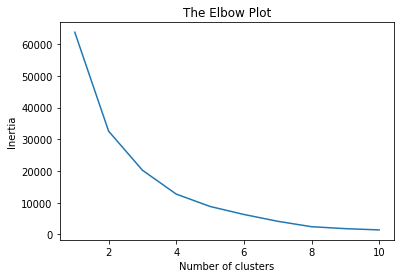

In [10]:
# Implementing UMAP to visualize dataset
u = umap.UMAP(n_neighbors=150, min_dist=0.4)
x_umap = u.fit_transform(X1)

# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(x_umap)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [11]:
# Running KMeans to generate labels
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_umap)

age = list(dataset['Age'])
gender = list(dataset['Gender'])
marital = list(dataset['MaritalStatus'])
education = list(dataset['Education'])
educationfield = list(dataset['EducationField'])
distance = list(dataset['DistanceFromHome'])

data = [go.Scatter(x=x_umap[:,0], y=x_umap[:,1], mode='markers',
                    marker = dict(color=kmeans.labels_, colorscale='Rainbow', opacity=0.5),
                                text=[f'Age: {a}; Gender: {b}; MaritalStatus:{c}, Education:{d}, EducationField:{e}, DistanceFromHome:{f}' for a,b,c,d,e,f in list(zip(age,gender,marital,education,educationfield,distance))],
                                hoverinfo='text')]

layout = go.Layout(title = 'UMAP Dimensionality Reduction', width = 700, height = 700,
                    xaxis = dict(title='First Dimension'),
                    yaxis = dict(title='Second Dimension'))
fig = go.Figure(data=data, layout=layout)
fig.show()

**Analysis on subset2 - Work Data**

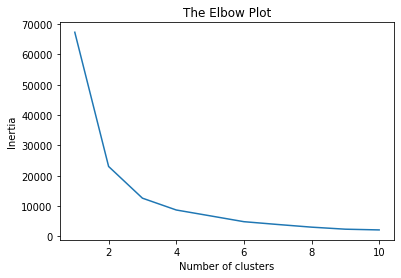

In [12]:
# Implementing UMAP to visualize dataset
u = umap.UMAP(n_neighbors=150, min_dist=0.4)
x_umap = u.fit_transform(X2)

# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(x_umap)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [13]:
# Running KMeans to generate labels
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_umap)

dpt = list(dataset['Department'])
ot = list(dataset['OverTime'])
so = list(dataset['StockOptionLevel'])
ttl = list(dataset['TrainingTimesLastYear'])
yac = list(dataset['YearsAtCompany'])
yic = list(dataset['YearsInCurrentRole'])
pr = list(dataset['PerformanceRating'])

data = [go.Scatter(x=x_umap[:,0], y=x_umap[:,1], mode='markers',
                    marker = dict(color=kmeans.labels_, colorscale='Rainbow', opacity=0.5),
                                text=[f'Dep: {a}; OverTime: {b}; SOL:{c}, TTL:{d}, YAC:{e}, YIC:{f}, PR:{g}' for a,b,c,d,e,f,g in list(zip(dpt,ot,so,ttl,yac,yic,pr))],
                                hoverinfo='text')]

layout = go.Layout(title = 'UMAP Dimensionality Reduction', width = 700, height = 700,
                    xaxis = dict(title='First Dimension'),
                    yaxis = dict(title='Second Dimension'))
fig = go.Figure(data=data, layout=layout)
fig.show()

**Analysis on subset3 - Life Quality Data**

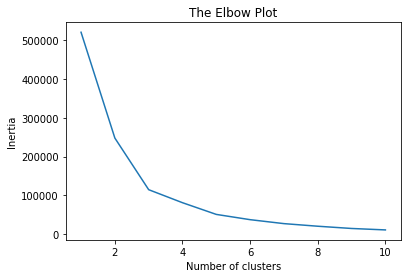

In [14]:
# Implementing UMAP to visualize dataset
u = umap.UMAP(n_neighbors=150, min_dist=0.4)
x_umap = u.fit_transform(X3)

# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(x_umap)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:
# Running KMeans to generate labels
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_umap)

JS = list(dataset['JobSatisfaction'])
ES = list(dataset['EnvironmentSatisfaction'])
JI = list(dataset['JobInvolvement'])
WLB = list(dataset['WorkLifeBalance'])

data = [go.Scatter(x=x_umap[:,0], y=x_umap[:,1], mode='markers',
                    marker = dict(color=kmeans.labels_, colorscale='Rainbow', opacity=0.5),
                                text=[f'JS: {a}; ES: {b}; JI:{c}, WLB:{d}' for a,b,c,d in list(zip(JS,ES,JI,WLB))],
                                hoverinfo='text')]

layout = go.Layout(title = 'UMAP Dimensionality Reduction', width = 700, height = 700,
                    xaxis = dict(title='First Dimension'),
                    yaxis = dict(title='Second Dimension'))
fig = go.Figure(data=data, layout=layout)
fig.show()

**Analysis on subset4 - Potential Churn Factors**

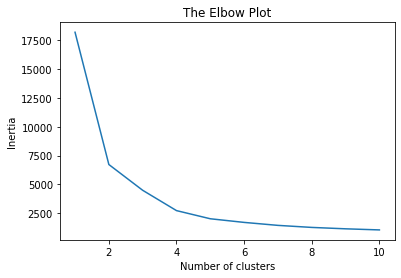

In [16]:
# Implementing UMAP to visualize dataset
u = umap.UMAP(n_neighbors=150, min_dist=0.4)
x_umap = u.fit_transform(X4)

# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(x_umap)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
# Running KMeans to generate labels
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_umap)

data = [go.Scatter(x=x_umap[:,0], y=x_umap[:,1], mode='markers',
                    marker = dict(color=kmeans.labels_, colorscale='Rainbow', opacity=0.5),
                                text=[f'JS: {a}; ES: {b}; JI:{c}, WLB:{d}, OverTime: {e}; SOL:{f}, YAC:{g}, YIC:{h}, PR:{i}' for a,b,c,d,e,f,g,h,i in list(zip(JS,ES,JI,WLB,ot,so,yac,yic,pr))],
                                hoverinfo='text')]

layout = go.Layout(title = 'UMAP Dimensionality Reduction', width = 700, height = 700,
                    xaxis = dict(title='First Dimension'),
                    yaxis = dict(title='Second Dimension'))
fig = go.Figure(data=data, layout=layout)
fig.show()
